## Mimic EDA
#### Predicting and Understanding Unexpected Respiratory Decompensation in Critical Care Using Sparse and Heterogeneous Clinical Data

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import mimic_utils as mimic
import magec_utils as mg

pd.set_option('display.max_columns', None)

random.seed(22891)

Using TensorFlow backend.


### MIMIC-III Data

In [2]:
# MIMIC-III
df = mimic.get_mimic_data()

### Get annotation data (if any) for patients in our cohort w/ advanced lung or heart disease

In [3]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')
df_anno = df_anno[((df_anno['ADVANCED.LUNG.DISEASE'] == 1) | 
                  (df_anno['ADVANCED.HEART.DISEASE'] == 1)) & 
                  (df_anno['ADVANCED.CANCER'] == 0)]
users = list(set(df.subject_id.unique()).intersection(set(df_anno.SUBJECT_ID.unique())))
len(users)

47

In [4]:
np.save('case_users', users)

### MIMIC-III Data Engineering

In [5]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

features = vitals+labs

# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df)
# Data featurized as time-series
df_time = mimic.get_ml_series_data(df)

_, x_validation, stsc, _, xst_validation, _, Y_validation = mimic.train_valid_ml(df_ml, include_valid='case_users.npy')

stsc2, _, df_series_valid, _, _, xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

### Load cohort data (demographics, vitals, labs and co-morbidities)

In [6]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

conn = engine.connect()
schema_name = 'mimiciii'
conn.execute('SET search_path to ' + schema_name)

In [7]:
df_cohort = pd.read_sql("select * from mimic_users_study;", conn)

### Get notes for patients in our cohort

In [8]:
from mimic_queries import notes_query
df_notes = pd.read_sql(notes_query(prior_hours=48), conn)

### Get meds for patients in our cohort

In [9]:
from mimic_queries import meds_query
df_meds = pd.read_sql(meds_query(prior_hours=48), conn)

In [10]:
conn.close()

### Get MAgEC results for validation data (2128 patients)

In [11]:
joined = pd.read_csv('time_mimic_magecs_valid.csv')
joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 
                                       'orig_prob_rf', 'orig_prob_lstm']].apply(np.mean, 1)

In [12]:
joined.case.nunique()

2128

### Find interesting patients

In [31]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours',
        'age', 'gender', 'ethnicity']

valid_cases = df_cohort[np.isin(df_cohort.subject_id, users)].\
               sort_values(['subject_id', 'timepoint']).\
               groupby(['subject_id'])[cols].first()

In [35]:
valid_cases[valid_cases['mv_hours'] > 0]

,subject_id,timepoint,admittime,admission_type,los_icu,diagnosis,curr_service,dischtime,mort_icu,mv_start,mv_end,mv_hours,age,gender,ethnicity
subject_id,,,,,,,,,,,,,,,
413,413,4,2105-08-12 11:04:00,EMERGENCY,12.0,PANCREATITIS,MED,2105-08-25 06:35:00,1,2105-08-13 13:00:00,2105-08-24 19:00:00,270.000000,82.0,1,other
433,433,3,2162-01-18 11:32:00,EMERGENCY,4.0,CONGESTIVE HEART FAILURE;TELEMETRY,CMED,2162-02-08 18:55:00,0,2162-02-02 20:20:00,2162-02-03 12:00:00,15.666667,49.0,0,black
2747,2747,3,2133-01-06 13:43:00,EMERGENCY,3.0,AORTIC VALVE DISEASE\CATH,CMED,2133-01-14 12:58:00,0,2133-01-07 18:45:00,2133-01-08 08:00:00,13.250000,52.0,1,white
2990,2990,4,2153-03-27 13:04:00,URGENT,61.0,CONGESTIVE HEART FAILURE,CMED,2153-05-29 10:30:00,0,2153-03-29 18:44:00,2153-03-30 07:00:00,12.266667,52.0,1,white
3482,3482,6,2148-12-23 16:42:00,EMERGENCY,6.0,CHEST PAIN,CMED,2148-12-30 13:30:00,0,2148-12-25 15:30:00,2148-12-26 06:00:00,14.500000,51.0,1,white
3935,3935,3,2150-01-30 21:25:00,EMERGENCY,4.0,CONGESTIVE HEART FAILURE-PNEUMONIA,MED,2150-02-11 13:14:00,0,2150-02-01 08:00:00,2150-02-01 11:00:00,3.000000,86.0,0,white
5544,5544,3,2114-04-03 17:02:00,EMERGENCY,5.0,UNSTABLE ANGINA,CMED,2114-04-16 17:52:00,0,2114-04-05 12:42:00,2114-04-05 14:32:00,1.833333,66.0,1,white
6451,6451,4,2164-09-10 16:24:00,URGENT,17.0,MI\CATH,CMED,2164-10-03 11:57:00,0,2164-09-13 13:20:00,2164-09-14 06:50:00,17.500000,65.0,1,white
7363,7363,5,2174-09-28 14:09:00,EMERGENCY,5.0,CHEST PAIN\CATH,CMED,2174-11-14 16:00:00,0,2174-09-29 15:00:00,2174-09-30 02:25:00,11.416667,65.0,1,white


In [122]:
# 6451, 19823
case = 29043
df_anno[df_anno.SUBJECT_ID==case].iloc[0]

HADM_ID                                           124645
SUBJECT_ID                                         29043
ROW_ID                                             32735
ADVANCED.CANCER                                        0
ADVANCED.HEART.DISEASE                                 0
ADVANCED.LUNG.DISEASE                                  1
ALCOHOL.ABUSE                                          0
BATCH.ID                                         08Apr16
CHRONIC.NEUROLOGICAL.DYSTROPHIES                       0
CHRONIC.PAIN.FIBROMYALGIA                              0
DEMENTIA                                               0
DEPRESSION                                             0
DEVELOPMENTAL.DELAY.RETARDATION                        0
NON.ADHERENCE                                          0
NONE                                                   0
OBESITY                                                0
OPERATOR                                             ETM
OTHER.SUBSTANCE.ABUSE          

In [123]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

{'Metoprolol', 'Morphine Sulfate (Syringe)', None}

In [124]:
print('\n***NEXT NOTE***\n\n'.join(df_notes[df_notes.subject_id==case].sort_values('charttime')['text'].values.tolist()))

[**2160-12-1**] 2:55 AM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 37991**]
 Reason: Please assess for infiltrates, signs of failure.
 Admitting Diagnosis: MYOCARDIAL INFARCTION\CATH
 ______________________________________________________________________________
                                 FINAL ADDENDUM
 ADDENDUM:  Findings were communicated to Dr. [**Last Name (STitle) 10823**] at the time of dictation
 over the phone by Dr. [**Last Name (STitle) 236**].


         DR. [**First Name4 (NamePattern1) 1833**] [**Last Name (NamePattern1) **]

 [**2160-12-1**] 2:55 AM
 CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 37991**]
 Reason: Please assess for infiltrates, signs of failure.
 Admitting Diagnosis: MYOCARDIAL INFARCTION\CATH
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  72 year old woman with COPD and C

In [125]:
t_min = df_cohort[df_cohort.subject_id==case]['timepoint'].min()
t_max = df_cohort[df_cohort.subject_id==case]['timepoint'].max()
print(t_min, t_max)

3 27


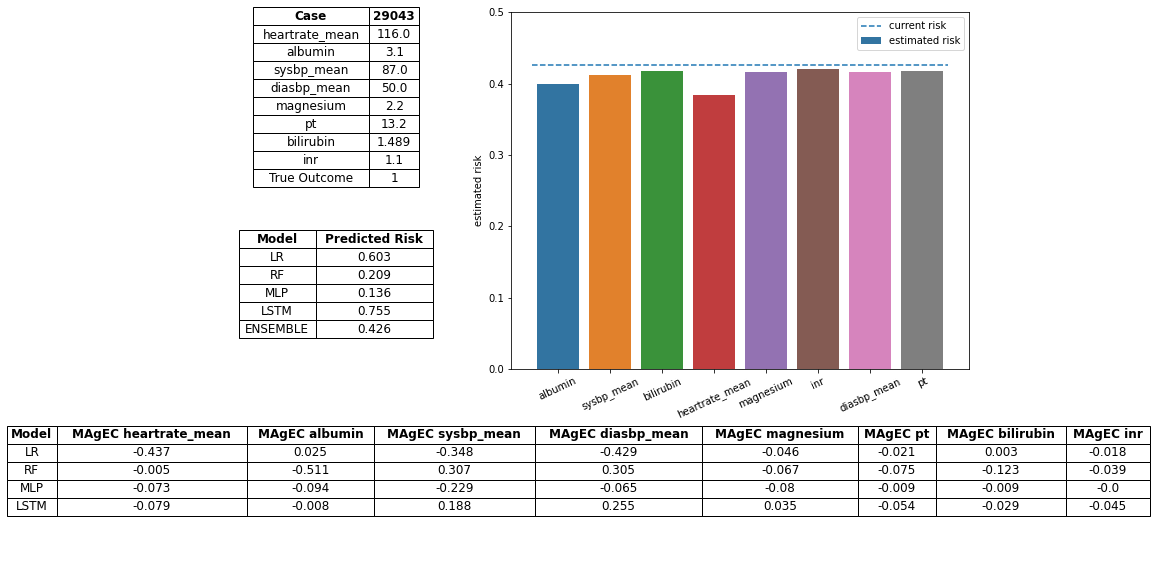

In [126]:
timepoint = t_max
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

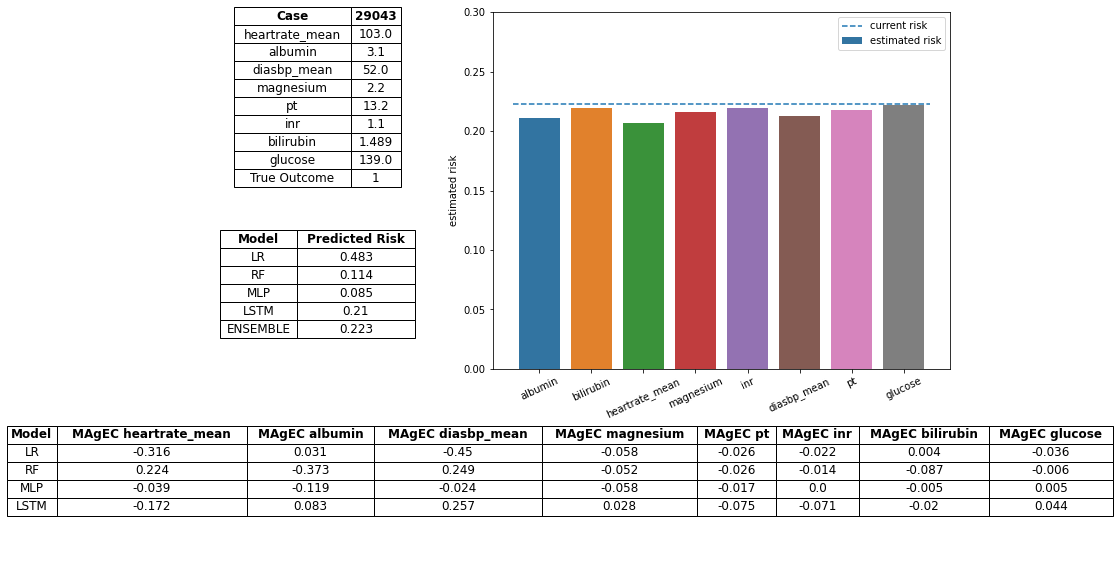

In [127]:
timepoint = t_min
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)